<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-1K/blob/main/A_B_Test_Food_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [3]:
url = 'https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/WA_Marketing-Campaign.csv'
data0 = pd.read_csv(url,error_bad_lines=False)
data0

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [4]:
df=data0
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object': 
        df[c] = df[c].fillna('NAN')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)
data1=df
data1

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,1,1,4,3,1,33.73
1,1,1,1,4,3,2,35.67
2,1,1,1,4,3,3,29.03
3,1,1,1,4,3,4,39.25
4,1,1,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,0,919,2,1,4,64.34
544,10,0,920,14,2,1,50.20
545,10,0,920,14,2,2,45.75
546,10,0,920,14,2,3,44.29


In [5]:
print(data1.columns.tolist())

['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion', 'week', 'SalesInThousands']


In [6]:
target=['SalesInThousands']
dataY=data1[target[0]]
dataX=data1.drop(target,axis=1)
print(dataY[0:5].T)
print()
print(dataX[0:5].T)

0    33.73
1    35.67
2    29.03
3    39.25
4    27.81
Name: SalesInThousands, dtype: float64

            0  1  2  3  4
MarketID    1  1  1  1  1
MarketSize  1  1  1  1  1
LocationID  1  1  1  1  2
AgeOfStore  4  4  4  4  5
Promotion   3  3  3  3  2
week        1  2  3  4  1


In [7]:
N=list(range(len(dataX)))
random.seed(2021)
random.shuffle(N)
n=len(dataX)
trainX=dataX.loc[N[0:(n//4)*3]]
trainY=dataY.loc[N[0:(n//4)*3]]
testX=dataX.loc[N[(n//4)*3:]]
testY=dataY.loc[N[(n//4)*3:]]
print(len(dataX))
print(len(trainX))
print(len(testX))

548
411
137


In [8]:
df_columns = list(dataX.columns)
print(df_columns)

['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion', 'week']


In [9]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 205.96it/s]


createcreate_numeric_feature  0.002[s]


100%|██████████| 1/1 [00:00<00:00, 238.49it/s]

createcreate_numeric_feature  0.002[s]


In [11]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}
y = trainY


In [12]:
print(y.shape)

(411,)


In [13]:
ydf=pd.DataFrame(y)
ydf

,SalesInThousands
121,87.90
242,54.37
183,52.88
216,48.18
151,75.61
...,...
245,62.63
260,24.75
527,66.10
307,30.81


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	valid_0's rmse: 4.96795
fit fold=0  0.067[s]
Fold 0 RMSLE: 4.9679

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's rmse: 5.61006
fit fold=1  0.036[s]
Fold 1 RMSLE: 5.6101

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's rmse: 6.04694
fit fold=2  0.034[s]
Fold 2 RMSLE: 6.0469

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's rmse: 5.44903
fit fold=3  0.030[s]
Fold 3 RMSLE: 5.4490

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's rmse: 5.46162
fit fold=4  0.037[s]
Fold 4 RMSLE: 5.4616

--------------------------------------------------
FINISHED | Whole RMSLE: 5.5167


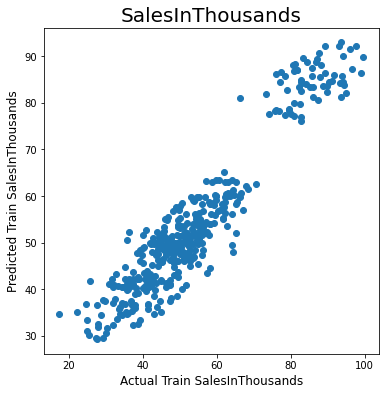

In [14]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('Predicted Train '+target[i],fontsize=12)
    ax.set_xlabel('Actual Train '+target[i],fontsize=12)
    ax.scatter(y,oof)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	valid_0's rmse: 4.96795
fit fold=0  0.066[s]
Fold 0 RMSLE: 4.9679

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's rmse: 5.61006
fit fold=1  0.037[s]
Fold 1 RMSLE: 5.6101

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's rmse: 6.04694
fit fold=2  0.041[s]
Fold 2 RMSLE: 6.0469

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's rmse: 5.44903
fit fold=3  0.029[s]
Fold 3 RMSLE: 5.4490

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's rmse: 5.46162
fit fold=4  0.040[s]
Fold 4 RMSLE: 5.4616

--------------------------------------------------
FINISHED | Whole RMSLE: 5.5167


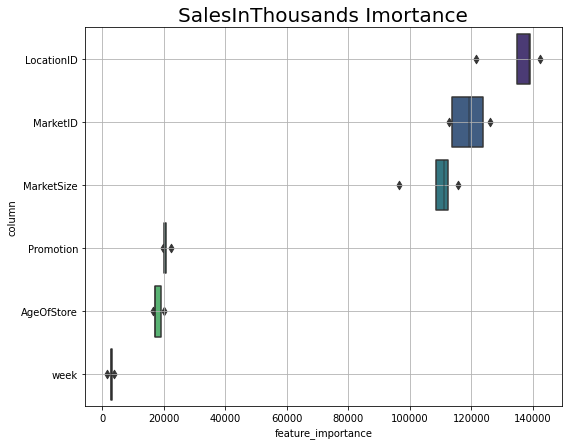

In [15]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [16]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
PRED = pred0[4]
PRED[0:5]

array([53.92580309, 44.40388593, 35.80356852, 29.46083145, 59.29976295])

In [17]:
ANS=np.array(testY)
ANS[0:5]

array([49.3 , 42.59, 39.25, 23.35, 61.59])

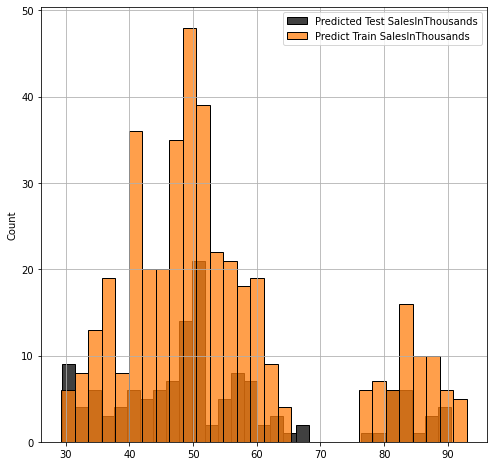

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(PRED, label='Predicted Test '+target[0], ax=ax, color='black',bins=30)
sns.histplot(oof, label='Predict Train '+target[0], ax=ax, color='C1',bins=30)
ax.legend()
ax.grid()

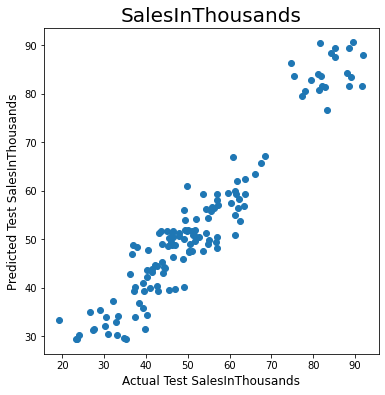

In [19]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[0],fontsize=20)
ax.set_xlabel('Actual Test '+target[0],fontsize=12)
ax.set_ylabel('Predicted Test '+target[0],fontsize=12)
ax.scatter(ANS,PRED)

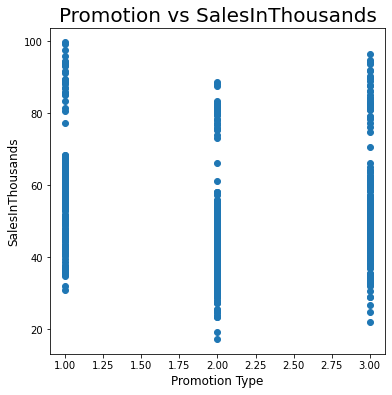

In [20]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('Promotion vs '+target[0],fontsize=20)
ax.set_xlabel('Promotion Type',fontsize=12)
ax.set_ylabel(target[0],fontsize=12)
ax.scatter(data1['Promotion'],data1[target[0]])